# IBM Advance Datascience Specialization - Capstone Project [Machine Learning]

#### Dataset Details: Real World Car Insurance Fraud Dataset - Non Synthetic.
Source: Kaggle<br>
URL : https://www.kaggle.com/datasets/incarnyx/car-insurance-fraud<br>
DataSet Description: https://www.kaggle.com/datasets/incarnyx/car-insurance-fraud/discussion/133719 <br>
Dataset More Information: https://sites.google.com/site/cliftonphua/publications?authuser=0

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4' 
from silence_tensorflow import silence_tensorflow
silence_tensorflow()


In [2]:
%matplotlib ipympl

In [3]:
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, TruncatedSVD, FastICA, IncrementalPCA
from sklearn.manifold import TSNE
import umap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, \
     RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import auc, roc_curve, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
import xgboost as xgb
import tensorflow as tf
import tfgraphviz as tfg
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Softmax, Dropout, BatchNormalization, Add, InputLayer
from tensorflow.keras.metrics import mae, mse, Accuracy, AUC
import dill as pickle
import logging
logging.getLogger('tensorflow').disabled = True
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(3)

## Loading Data

In [4]:
df = pd.read_excel('./Dataset.xlsx', 
                   sheet_name = 'Sheet1')



### Data preparation I - Encoding String Categorical Columns

In [5]:

df_encoded = df.copy()
mean_age = df_encoded['Age'].mean()
df_encoded['Age'] = df_encoded['Age'].fillna(mean_age)
mean_DriverRating = df_encoded['DriverRating'].mean()
df_encoded['DriverRating'] = df_encoded['DriverRating'].fillna(mean_DriverRating)
df_encoded = df_encoded.dropna().reset_index(drop=True)
df_encoded.name = "Insurance Fraud Data"


label_encoder = preprocessing.LabelEncoder()

cols_to_encode = ['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'BasePolicy', \
                   'NumberOfCars', 'AddressChange_Claim', 'NumberOfSuppliments', 'WitnessPresent', 'PoliceReportFiled', \
                   'AgeOfPolicyHolder', 'AgeOfVehicle', 'Days_Policy_Claim', 'Days_Policy_Accident', 'PastNumberOfClaims', \
                   'Sex', 'MaritalStatus', 'AgentType', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice']

for col in cols_to_encode:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col].astype(str))

In [6]:
print("number of columns =", len(df_encoded.columns))
print("number of feature columns =", len(df_encoded.columns)-1)
print("number of rows(data points) =", len(df_encoded.index))
print(df_encoded.describe())


number of columns = 34
number of feature columns = 33
number of rows(data points) = 11565
              Month   WeekOfMonth     DayOfWeek          Make  AccidentArea  \
count  11565.000000  11565.000000  11565.000000  11565.000000  11565.000000   
mean       5.537916      2.784003      2.897103     10.097968      0.895460   
std        3.419841      1.284854      2.048900      5.276479      0.305972   
min        0.000000      1.000000      0.000000      0.000000      0.000000   
25%        3.000000      2.000000      1.000000      6.000000      1.000000   
50%        6.000000      3.000000      3.000000      9.000000      1.000000   
75%        8.000000      4.000000      5.000000     13.000000      1.000000   
max       11.000000      5.000000      6.000000     18.000000      1.000000   

       DayOfWeekClaimed  MonthClaimed  WeekOfMonthClaimed           Sex  \
count      11565.000000  11565.000000        11565.000000  11565.000000   
mean           4.219628      6.583744           

In [7]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11565 entries, 0 to 11564
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Month                 11565 non-null  int64  
 1   WeekOfMonth           11565 non-null  int64  
 2   DayOfWeek             11565 non-null  int64  
 3   Make                  11565 non-null  int64  
 4   AccidentArea          11565 non-null  int64  
 5   DayOfWeekClaimed      11565 non-null  int64  
 6   MonthClaimed          11565 non-null  int64  
 7   WeekOfMonthClaimed    11565 non-null  int64  
 8   Sex                   11565 non-null  int64  
 9   MaritalStatus         11565 non-null  int64  
 10  Age                   11565 non-null  float64
 11  Fault                 11565 non-null  int64  
 12  PolicyType            11565 non-null  int64  
 13  VehicleCategory       11565 non-null  int64  
 14  VehiclePrice          11565 non-null  int64  
 15  FraudFound_P       

## PART1: Machine Learning Models
Now we explore various Machine Learning models for best AUC scores on our data<br>
We perform hyperparameter tuning for 6 models and compare the rezults

### Data Preparation II - Splitting And Scaling - Test and Train Data

In [10]:
X_f = df_encoded.drop('FraudFound_P', axis = 1).values
y_f = df_encoded['FraudFound_P'].values

X_train, X_test, y_train, y_test = train_test_split(
                    X_f, y_f, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
dic_AUC ={}
dic_accuracy = {}
dic_param = {}
dic_report = {}

#### Random forest Booster Hyperparameter tuning

In [12]:
clf = RandomForestClassifier()
# Sequential search of parameters, using  fold cross validation, 
# search across different combinations, and use all available cores

nm = 'RandomF'
train_features = X_train
train_label = y_train

random_grid = {'n_estimators': [61, 100, 161, 262, 423],
               'max_depth': [5, 8, 13, 21, None],
               'bootstrap': [True, False]}

clf_CV = GridSearchCV(estimator = clf, param_grid = random_grid,
                               cv = 5, verbose=0, n_jobs = -1, scoring='balanced_accuracy')
clf_CV.fit(train_features, train_label)

print('Grid best parameters (max. balanced_accuracy): ')
pprint.pprint(clf_CV.best_params_)
print('Grid best score (balanced_accuracy):', clf_CV.best_score_)

y_test_op = clf_CV.predict(X_test)

accr = accuracy_score(y_test_op, y_test)
rep = classification_report(y_test_op, y_test)
print("Report on test data for ", nm, '\n', rep)
print("Accuracy on test data for ", nm, ":", accr)

dic_AUC[nm]=clf_CV.best_score_
dic_accuracy[nm]=accr
dic_param[nm]= clf_CV.best_params_
dic_report[nm]=rep


Grid best parameters (max. balanced_accuracy): 
{'bootstrap': False, 'max_depth': 21, 'n_estimators': 61}
Grid best score (balanced_accuracy): 0.5060272480924712
Report on test data for  RandomF 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      2306
           1       0.04      0.86      0.08         7

    accuracy                           0.94      2313
   macro avg       0.52      0.90      0.53      2313
weighted avg       1.00      0.94      0.97      2313

Accuracy on test data for  RandomF : 0.9433635970600951


#### ADA Booster Hyperparameter tuning

In [13]:
clf = AdaBoostClassifier()
# Sequential search of parameters, using  fold cross validation, 
# search across different combinations, and use all available cores

nm = 'ADA-B'
train_features = X_train
train_label = y_train

random_grid = {'n_estimators': [2, 4, 6, 11, 18, 29],
    'learning_rate': [(x / 20) for x in range(1, 20)],
    'algorithm': ['SAMME', 'SAMME.R']}

clf_CV = GridSearchCV(estimator = clf, param_grid = random_grid,
                               cv = 5, verbose=0, n_jobs = -1, scoring='balanced_accuracy')
clf_CV.fit(train_features, train_label)

print('Grid best parameters (max. balanced_accuracy): ')
pprint.pprint(clf_CV.best_params_)
print('Grid best score balanced_accuracy:', clf_CV.best_score_)

y_test_op = clf_CV.predict(X_test)

accr = accuracy_score(y_test_op, y_test)
rep = classification_report(y_test_op, y_test)
print("Report on test data for ", nm, '\n', rep)
print("Accuracy on test data for ", nm, ":", accr)

dic_AUC[nm]=clf_CV.best_score_
dic_accuracy[nm]=accr
dic_param[nm]= clf_CV.best_params_
dic_report[nm]=rep

Grid best parameters (max. balanced_accuracy): 
{'algorithm': 'SAMME.R', 'learning_rate': 0.95, 'n_estimators': 6}
Grid best score balanced_accuracy: 0.5050994005895073
Report on test data for  ADA-B 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      2313
           1       0.00      0.00      0.00         0

    accuracy                           0.94      2313
   macro avg       0.50      0.47      0.48      2313
weighted avg       1.00      0.94      0.97      2313

Accuracy on test data for  ADA-B : 0.9412019022913964


#### Gradient Boosting Classifier Hyperparameter Tuning

In [14]:
clf = GradientBoostingClassifier()
# Sequential search of parameters, using  fold cross validation, 
# search across different combinations, and use all available cores

nm = 'GB-Tree'
train_features = X_train
train_label = y_train

random_grid = {'n_estimators': [61, 100, 161, 262, 423, 684],
               'max_depth': [3, 5, 8, 13],
               'learning_rate': [(x / 200) for x in range(1, 200, 5)]
              }

clf_CV = GridSearchCV(estimator = clf, param_grid = random_grid,
                               cv = 5, verbose=0, n_jobs = -1, scoring='balanced_accuracy')
clf_CV.fit(train_features, train_label)

print('Grid best parameters (max. balanced_accuracy): ')
pprint.pprint(clf_CV.best_params_)
print('Grid best score (balanced_accuracy):', clf_CV.best_score_)

y_test_op = clf_CV.predict(X_test)

accr = accuracy_score(y_test_op, y_test)
rep = classification_report(y_test_op, y_test)
print("Report on test data for ", nm, '\n', rep)
print("Accuracy on test data for ", nm, ":", accr)

dic_AUC[nm]=clf_CV.best_score_
dic_accuracy[nm]=accr
dic_param[nm]= clf_CV.best_params_
dic_report[nm]=rep

Grid best parameters (max. balanced_accuracy): 
{'learning_rate': 0.63, 'max_depth': 5, 'n_estimators': 61}
Grid best score (balanced_accuracy): 0.622575295456419
Report on test data for  GB-Tree 
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      2254
           1       0.26      0.61      0.37        59

    accuracy                           0.95      2313
   macro avg       0.63      0.78      0.67      2313
weighted avg       0.97      0.95      0.96      2313

Accuracy on test data for  GB-Tree : 0.9468223086900129


#### Histogram Baised Gradient Boosting Tree Classifier Hyperparameter tuning

In [15]:
clf = HistGradientBoostingClassifier()
# Sequential search of parameters, using  fold cross validation, 
# search across different combinations, and use all available cores

nm = 'HGB-Tree'
train_features = X_train
train_label = y_train

random_grid = {'max_depth': [3, 5, 8, 13, 18, 29],
               'learning_rate': [(x / 200) for x in range(1, 200, 5)],
               'max_iter': [61, 100, 161, 262, 423]
              }

clf_CV = GridSearchCV(estimator = clf, param_grid = random_grid,
                               cv = 5, verbose=0, n_jobs = -1, scoring='balanced_accuracy')#'f1_weighted'
clf_CV.fit(train_features, train_label)

print('Grid best parameters (max. balanced_accuracy): ')
pprint.pprint(clf_CV.best_params_)
print('Grid best score (balanced_accuracy):', clf_CV.best_score_)

y_test_op = clf_CV.predict(X_test)

accr = accuracy_score(y_test_op, y_test)
rep = classification_report(y_test_op, y_test)
print("Report on test data for ", nm, '\n', rep)
print("Accuracy on test data for ", nm, ":", accr)

dic_AUC[nm]=clf_CV.best_score_
dic_accuracy[nm]=accr
dic_param[nm]= clf_CV.best_params_
dic_report[nm]=rep

Grid best parameters (max. balanced_accuracy): 
{'learning_rate': 0.68, 'max_depth': 3, 'max_iter': 423}
Grid best score (balanced_accuracy): 0.6696133647511711
Report on test data for  HGB-Tree 
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      2241
           1       0.35      0.65      0.45        72

    accuracy                           0.95      2313
   macro avg       0.67      0.81      0.71      2313
weighted avg       0.97      0.95      0.96      2313

Accuracy on test data for  HGB-Tree : 0.9507133592736705


#### Extra Trees Classifier Hyperparameter Tuning

In [16]:
clf = ExtraTreesClassifier()
# Sequential search of parameters, using  fold cross validation, 
# search across different combinations, and use all available cores

nm = 'Ex-Tree'
train_features = X_train
train_label = y_train

random_grid = {'n_estimators': [100, 161, 262, 423, 684],
               'max_depth': [5, 8, 13, 21],
               'max_features': ['auto','sqrt','log2'],
              }

clf_CV = GridSearchCV(estimator = clf, param_grid = random_grid,
                               cv = 5, verbose=0, n_jobs = -1, scoring='balanced_accuracy')
clf_CV.fit(train_features, train_label)

print('Grid best parameters (max. balanced_accuracy): ')
pprint.pprint(clf_CV.best_params_)
print('Grid best score (balanced_accuracy):', clf_CV.best_score_)

y_test_op = clf_CV.predict(X_test)

accr = accuracy_score(y_test_op, y_test)
rep = classification_report(y_test_op, y_test)
print("Report on test data for ", nm, '\n', rep)
print("Accuracy on test data for ", nm, ":", accr)

dic_AUC[nm]=clf_CV.best_score_
dic_accuracy[nm]=accr
dic_param[nm]= clf_CV.best_params_
dic_report[nm]=rep

Grid best parameters (max. balanced_accuracy): 
{'max_depth': 21, 'max_features': 'sqrt', 'n_estimators': 100}
Grid best score (balanced_accuracy): 0.5016458010355691
Report on test data for  Ex-Tree 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      2311
           1       0.00      0.00      0.00         2

    accuracy                           0.94      2313
   macro avg       0.50      0.47      0.48      2313
weighted avg       1.00      0.94      0.97      2313

Accuracy on test data for  Ex-Tree : 0.940337224383917


#### XGboost Classifier Hyperparameter tuning

In [17]:
param_test0 = {
 'max_depth':[i for i in range(3, 24, 3)],
 'min_child_weight':[i for i in range(1,10)],
}

gsearch0 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27), 
 param_grid = param_test0, scoring='balanced_accuracy',n_jobs=-1, cv=5)
gsearch0.fit(X_train,y_train)
print(gsearch0.best_params_, gsearch0.best_score_)

{'max_depth': 9, 'min_child_weight': 4} 0.5574426919847604


In [18]:
#we fix the parameters max_depth=9 and min_child_weight=4

param_test1 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
 'n_estimators': [61, 100, 161, 262, 423],
 'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2, 0.33]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=4, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='balanced_accuracy',n_jobs=4, cv=5)
_ = gsearch1.fit(X_train,y_train)

In [19]:
nm= 'XGBoost'

print('Grid best parameters (max. balanced_accuracy): ')
pprint.pprint(gsearch1.best_params_)
print('Grid best score (balanced_accuracy):', gsearch1.best_score_)

y_test_op = gsearch1.predict(X_test)

accr = accuracy_score(y_test_op, y_test)
rep = classification_report(y_test_op, y_test)
print("Report on test data for ", nm, '\n', rep)
print("Accuracy on test data for ", nm, ":", accr)

dic_AUC[nm]=clf_CV.best_score_
dic_accuracy[nm]=accr
dic_param[nm]= clf_CV.best_params_
dic_report[nm]=rep

Grid best parameters (max. balanced_accuracy): 
{'colsample_bytree': 0.6,
 'learning_rate': 0.33,
 'n_estimators': 423,
 'subsample': 0.9}
Grid best score (balanced_accuracy): 0.5986584931645405
Report on test data for  XGBoost 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      2282
           1       0.14      0.61      0.23        31

    accuracy                           0.94      2313
   macro avg       0.57      0.78      0.60      2313
weighted avg       0.98      0.94      0.96      2313

Accuracy on test data for  XGBoost : 0.9442282749675746


####  A Side By Side Comparison of Various Classifiers on Predicting Insurance Fraud Data

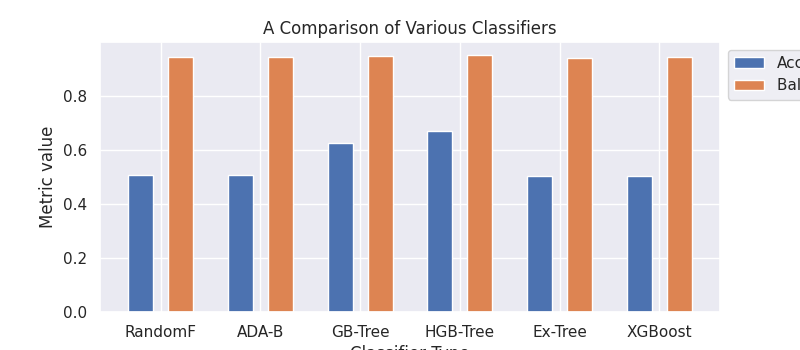

In [20]:
X = list(dic_AUC.keys())
Y = list(dic_AUC.values())
Z = list(dic_accuracy.values())

X_axis = np.arange(len(X))

plt.figure(figsize = (8, 3.5))
sns.set(style = "darkgrid")
plt.bar(X_axis - 0.2, Y, 0.25, label = 'Accuracy')
plt.bar(X_axis + 0.2, Z, 0.25, label = 'Balanced Accuracy')
  
plt.xticks(X_axis, X)
plt.xlabel("Classifier Type")
plt.ylabel("Metric value")
plt.title("A Comparison of Various Classifiers")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

### Iterations in Model Process - Apply PCA, UMAP transforms and investigate model performance

In [21]:
#we assume 98% of data covariances to be contained in 17 components across all transfoms

MAX_COMPONENTS = 17

pca = PCA(n_components=MAX_COMPONENTS, random_state = 1)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

umap_m = umap.UMAP(
    n_components=MAX_COMPONENTS, 
    random_state=1, 
    n_neighbors=5
)
X_umap_train = umap_m.fit_transform(X_train)
X_umap_test = umap_m.transform(X_test)


#### Histogram Baised Gradient Boosting Tree Classifier Hyperparameter tuning - PCA transform

In [22]:
dic_AUC_t ={}
dic_accuracy_t={}
dic_AUC_t['HGB'] = 0.669613
dic_accuracy_t['HGB'] = 0.950713

In [23]:
clf = HistGradientBoostingClassifier()
# Sequential search of parameters, using  fold cross validation, 
# search across different combinations, and use all available cores

nm = 'HGB-Tree-PCA'
train_features = X_pca_train
train_label = y_train

random_grid = {'max_depth': [3, 5, 8, 13, 18, 29],
               'learning_rate': [(x / 200) for x in range(1, 200, 5)],
               'max_iter': [61, 100, 161, 262, 423]
              }

clf_CV = GridSearchCV(estimator = clf, param_grid = random_grid,
                               cv = 5, verbose=0, n_jobs = -1, scoring='balanced_accuracy')#'f1_weighted'
clf_CV.fit(train_features, train_label)

print('Grid best parameters (max. balanced_accuracy): ')
pprint.pprint(clf_CV.best_params_)
print('Grid best score (balanced_accuracy):', clf_CV.best_score_)

y_test_op = clf_CV.predict(X_pca_test)

accr = accuracy_score(y_test_op, y_test)
rep = classification_report(y_test_op, y_test)
print("Report on test data for ", nm, '\n', rep)
print("Accuracy on test data for ", nm, ":", accr)

dic_AUC_t[nm]=clf_CV.best_score_
dic_accuracy_t[nm]=accr

Grid best parameters (max. balanced_accuracy): 
{'learning_rate': 0.93, 'max_depth': 13, 'max_iter': 61}
Grid best score (balanced_accuracy): 0.5500517062946458
Report on test data for  HGB-Tree-PCA 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      2225
           1       0.15      0.24      0.19        88

    accuracy                           0.92      2313
   macro avg       0.56      0.59      0.57      2313
weighted avg       0.94      0.92      0.93      2313

Accuracy on test data for  HGB-Tree-PCA : 0.9213143104193687


#### Histogram Baised Gradient Boosting Tree Classifier Hyperparameter tuning- UMAP transform

In [24]:
clf = HistGradientBoostingClassifier()
# Sequential search of parameters, using  fold cross validation, 
# search across different combinations, and use all available cores

nm = 'HGB-Tree-UMAP'
train_features = X_umap_train
train_label = y_train

random_grid = {'max_depth': [3, 5, 8, 13, 18, 29],
               'learning_rate': [(x / 200) for x in range(1, 200, 5)],
               'max_iter': [61, 100, 161, 262, 423]
              }

clf_CV = GridSearchCV(estimator = clf, param_grid = random_grid,
                               cv = 5, verbose=0, n_jobs = -1, scoring='balanced_accuracy')#'f1_weighted'
clf_CV.fit(train_features, train_label)

print('Grid best parameters (max. balanced_accuracy): ')
pprint.pprint(clf_CV.best_params_)
print('Grid best score (balanced_accuracy):', clf_CV.best_score_)

y_test_op = clf_CV.predict(X_umap_test)

accr = accuracy_score(y_test_op, y_test)
rep = classification_report(y_test_op, y_test)
print("Report on test data for ", nm, '\n', rep)
print("Accuracy on test data for ", nm, ":", accr)

dic_AUC_t[nm]=clf_CV.best_score_
dic_accuracy_t[nm]=accr

Grid best parameters (max. balanced_accuracy): 
{'learning_rate': 0.555, 'max_depth': 29, 'max_iter': 423}
Grid best score (balanced_accuracy): 0.5335173586147328
Report on test data for  HGB-Tree-UMAP 
               precision    recall  f1-score   support

           0       0.97      0.94      0.96      2245
           1       0.08      0.16      0.11        68

    accuracy                           0.92      2313
   macro avg       0.53      0.55      0.53      2313
weighted avg       0.95      0.92      0.93      2313

Accuracy on test data for  HGB-Tree-UMAP : 0.9213143104193687


####  A Side By Side Comparison of Effects of Various Dimensionality Reducing Transforms on Predicting Insurance Fraud Data

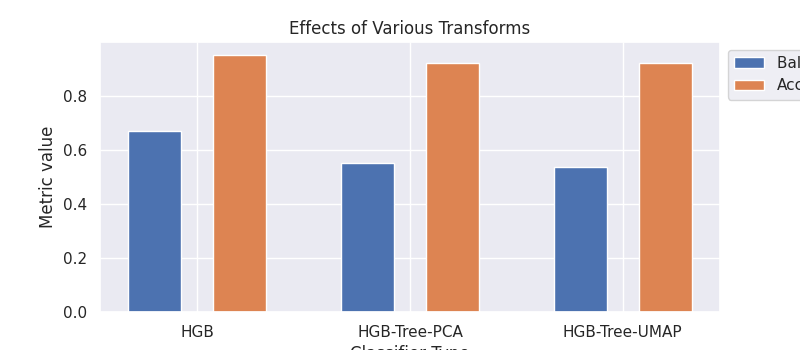

In [26]:
X = list(dic_AUC_t.keys())
Y = list(dic_AUC_t.values())
Z = list(dic_accuracy_t.values())

X_axis = np.arange(len(X))

plt.figure(figsize = (8, 3.5))
sns.set(style = "darkgrid")
plt.bar(X_axis - 0.2, Y, 0.25, label = 'Balanced Accuracy')
plt.bar(X_axis + 0.2, Z, 0.25, label = 'Accuracy')
  
plt.xticks(X_axis, X)
plt.xlabel("Classifier Type")
plt.ylabel("Metric value")
plt.title("Effects of Various Transforms")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

#### Conclusion On Dimensionality Reduction Transforms

On applying various dimensionality reduction techniques we do not see an increase in overall accuracy or balance accuracy score.<br>
On the contrary both the accuracy and balanced accuracy scores decrease slightly on application of the dimensionality reduction transforms.<br>
Thus we can conclude that dimensionality reduction transforms are not appplicable or required for processing this dataset.